### Ejercicio N°1. Aprendizaje Q para una variable de estado


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Parametros
TM = 2000
Mmax = 15
etapas = 6
xmin, xmax = 0, 3
umin, umax = -1, 1

In [2]:
# Inicialización de datos
np.random.seed(0)
equis1 = 3 * np.random.rand(TM)
tiempo = np.ceil((etapas - 1) * np.random.rand(TM)).astype(int)
M_est = np.array([tiempo, equis1])
Au = (umax - umin) / (Mmax - 1)
uf = [umin + Au * i for i in range(Mmax)]

In [3]:
# Condiciones iniciales
CI = 2
vfinal = 1
Q = np.zeros((TM, Mmax))
J = np.zeros(TM)
sal = [CI]
costo = [0]
Ya = np.zeros(TM)

In [4]:
# Función look up table
def pol_tab_mu1(entrada, M_est, Ya):
    diff = np.abs((entrada[0] - M_est[0, :]) / 3) + np.abs((entrada[1] - M_est[1, :]) / 6)
    in_index = np.argmin(diff)
    return Ya[in_index]
# Modelo
def mopdm(k, x, u):
    # Placeholder for mopdm function
    return x + (2 - 2 * x + 5 / 4 * x**2 - 1 / 4 * x**3) * u
# Función de Costo
def indice(k, x, u):
    # Placeholder for indice function
    return (2 + u) * np.exp(-x)

In [5]:
# Simulación inicial para una politica inicial
for k in range(etapas - 1):
    entrada = [k, sal[k]]
    consigna = pol_tab_mu1(entrada, M_est, Ya)
    sal.append(mopdm(k, sal[k], consigna))
    costo.append(costo[k] + indice(k, sal[k], consigna))

costo[-1] += abs(sal[-1] - vfinal)
evoluc = [costo[-1]]
m = np.zeros((TM, Mmax))

In [6]:
for iterac in range(15):
    # Recorremos todos las muestras
    for iq in range(TM):
        k, x = M_est[:, iq]
        # Recorremos todos las acciones
        for acc in range(Mmax):
            xy = mopdm(k, x, uf[acc])
            m[iq, acc] += 1
            gama = 0.10 * m[iq, acc] / (1.0 + 0.10 * m[iq, acc])
            # Actualización de los Q
            if k < etapas - 1:
                diffs = np.abs(((k + 1) - M_est[0, :]) / max(M_est[0, :])) + np.abs((xy - M_est[1, :]) / max(M_est[1, :]))
                lugar = np.argmin(diffs)
                Q[iq, acc] = (1 - gama) * Q[iq, acc] + gama * (indice(k, x, uf[acc]) + J[lugar])
            else:
                Q[iq, acc] = (1 - gama) * Q[iq, acc] + gama * (indice(k, x, uf[acc]) + abs(xy - vfinal))
    # Actualizamos la politica y los costos recorriendo todos los estados
    for iq in range(TM):
        val, lugar = min((val, idx) for idx, val in enumerate(Q[iq, :]))
        J[iq] = val
        Ya[iq] = uf[lugar]
    # Simulamos las etapas con la politica actualizada
    sal = [CI]
    costo = [0]
    for k in range(etapas - 1):
        entrada = [k, sal[k]]
        consigna = pol_tab_mu1(entrada, M_est, Ya)
        sal.append(mopdm(k, sal[k], consigna))
        costo.append(costo[k] + indice(k, sal[k], consigna))

    costo[-1] += abs(sal[-1] - vfinal)
    evoluc.append(costo[-1])

In [7]:
# Resultados
costo_results = np.zeros((4, etapas))
estado = np.zeros_like(costo_results)
u_opt = np.zeros_like(costo_results)
# Simulamos para distintas condiciones iniciales
for CI in range(1, 5):
    in_val = CI - 1
    estado[CI - 1, 0] = in_val
    for k in range(etapas - 1):
        entrada = [k, in_val]
        an = pol_tab_mu1(entrada, M_est, Ya)
        u_opt[CI - 1, k] = an
        costo_results[CI - 1, k + 1] = indice(k, in_val, an) + costo_results[CI - 1, k]
        in_val = mopdm(k, in_val, an)
        estado[CI - 1, k + 1] = in_val

    costo_results[CI - 1, -1] += abs(in_val - 1)

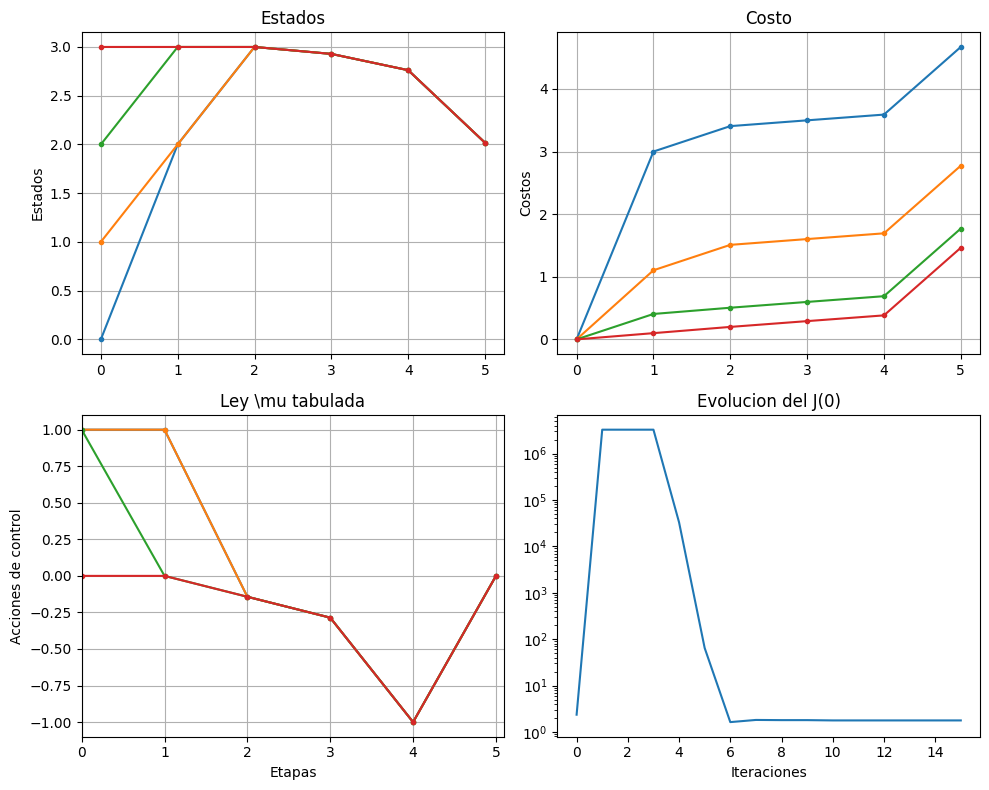

In [8]:
xx = np.arange(etapas)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(xx, estado.T, '.-')
axs[0, 0].set_title('Estados')
axs[0, 0].set_ylabel('Estados')
axs[0, 0].grid(True)

axs[0, 1].plot(xx, costo_results.T, '.-')
axs[0, 1].set_title('Costo')
axs[0, 1].set_ylabel('Costos')
axs[0, 1].grid(True)

axs[1, 0].plot(xx[:u_opt.shape[1]], u_opt.T, '.-')
axs[1, 0].set_title('Ley \mu tabulada')
axs[1, 0].set_ylabel('Acciones de control')
axs[1, 0].set_xlabel('Etapas')
axs[1, 0].grid(True)
axs[1, 0].set_xlim(0, etapas - 0.9)
axs[1, 0].set_ylim(-1.1, 1.1)

axs[1, 1].semilogy(evoluc)
axs[1, 1].set_title('Evolucion del J(0)')
axs[1, 1].set_xlabel('Iteraciones')

plt.tight_layout()



### Ejercicio N°2. Aprendizaje Q para el péndulo invertido


#### Aprendizaje Q Pendulo *Invertido*

Planteamos una posible implementacion de aprendizaje Q para el caso del Péndulo Invertido

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Parametros
TM = 2000  # Numero de estados espacio estado-accion
Mmax = 15  # Numero de acciones discretas
etapas = 50  # Numero de estapas
xmin, xmax = -np.pi, np.pi  # Rango de los estados (angulos radianes)
umin, umax = -10, 10  # Rango del control en N

In [10]:
# Constantes fisicas del péndulo
g = 9.8  # Gravedad (m/s^2)
L = 1.0  # Largo del péndulo (m)
m = 1.0  # masa del péndulo(kg)

In [11]:
# Inicialización de Datos
np.random.seed(0)
angles = 2 * np.pi * (np.random.rand(TM) - 0.5)  # Angulos iniciales (-pi a pi)
angular_velocities = 4 * (np.random.rand(TM) - 0.5)  # Velocidades Angulares (-2 a 2)
tiempo = np.ceil((etapas - 1) * np.random.rand(TM)).astype(int)
M_est = np.array([tiempo, angles, angular_velocities]) # Matriz de estados
Au = (umax - umin) / (Mmax - 1) # salto discreto
uf = [umin + Au * i for i in range(Mmax)] # acciones

In [12]:
# Condiciones Iniciales
CI = [np.pi, 0.0]  # Posición de la masa en pi sin velocidad angular
vfinal = [0.0, 0.0]  # Estado final deseado
Q = np.zeros((TM, Mmax))  # Tabla acción-estado
J = np.zeros(TM)  # Costo
Ya = np.zeros(TM)  # Accion optima por estado

# Matrices de costo
costo = [0]
evoluc = [0]
m_gamma = np.zeros((TM, Mmax))

In [13]:
# Dinamica de el pendulo invertido
def pendulum_dynamics(theta, theta_dot, u, dt=0.05):
    theta_ddot = (g / L) * np.sin(theta) + (u / (m * L**2))
    theta_new = theta + theta_dot * dt
    theta_dot_new = theta_dot + theta_ddot * dt
    return theta_new, theta_dot_new

# Costo inmediato: funcion de costo de mínima energia como LQR
def cost_function(theta, theta_dot, u):
    return 10*theta**2 + 0.1 * theta_dot**2 + 0.01 * u**2

# tabla de politica de control
def pol_tab_mu1(entrada, M_est, Ya):
    diff = np.abs((entrada[0] - M_est[0, :]) / 3) + np.abs((entrada[1] - M_est[1, :]) / (2 * np.pi)) + np.abs((entrada[2] - M_est[2, :]) / 4)
    in_index = np.argmin(diff)
    return Ya[in_index]

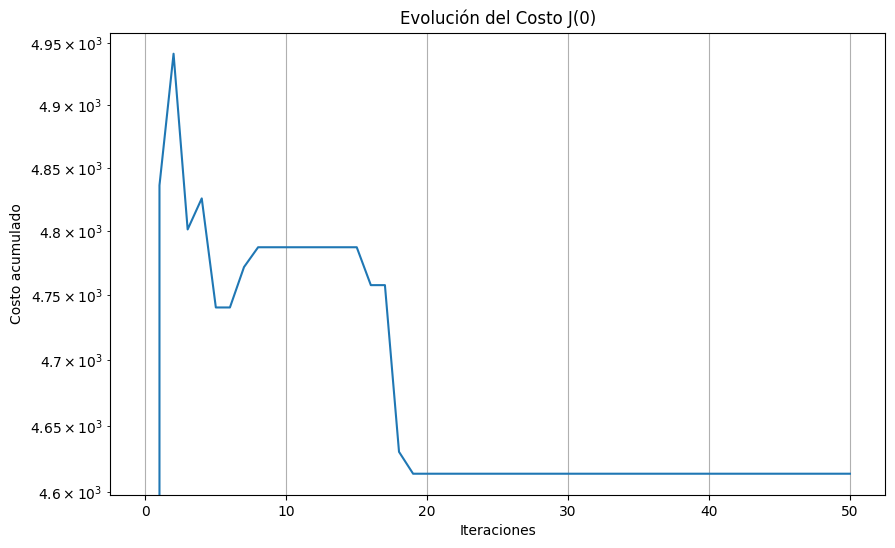

Execution time: 91.89733004570007 seconds


In [14]:
# Optimización
start_time = time.time()
# Iteramos n veces
for iterac in range(50):
    # Recorremos todos las muestras
    for iq in range(TM):
        k, theta, theta_dot = M_est[:, iq]
        # Recorremos todas las acciones
        for acc in range(Mmax):
            u = uf[acc] # elegimos la acción
            theta_new, theta_dot_new = pendulum_dynamics(theta, theta_dot, u) # actuamos sobre el sistema y obtenemos el estado siguiente
            m_gamma[iq, acc] += 1
            # actualizamos gamma para cada iteración
            gama = 0.10 * m_gamma[iq, acc] / (1.0 + 0.10 * m_gamma[iq, acc])
            # Actualizamos Q
            if k < etapas - 1:
                diffs = np.abs(k+1 - M_est[0, :]) / 3 + np.abs((theta_new - M_est[1, :]) / (2 * np.pi)) + np.abs((theta_dot_new - M_est[2, :]) / 4)
                lugar = np.argmin(diffs)
                Q[iq, acc] = (1 - gama) * Q[iq, acc] + gama * (cost_function(theta, theta_dot, u) + J[lugar])
            else:
                Q[iq, acc] = (1 - gama) * Q[iq, acc] + gama * (cost_function(theta, theta_dot, u) + np.linalg.norm([theta_new, theta_dot_new] - np.array(vfinal)))
    # Una vez actualizado Q encontramos la politica optima mediante un argmin en Q
    for iq in range(TM):
        val, lugar = min((val, idx) for idx, val in enumerate(Q[iq, :]))
        J[iq] = val
        Ya[iq] = uf[lugar]

    # Simulamos con la politica ya actualizada
    theta, theta_dot = CI
    costo = [0]
    for k in range(etapas - 1):
        entrada = [k, theta, theta_dot]
        u = pol_tab_mu1(entrada, M_est, Ya)
        theta, theta_dot = pendulum_dynamics(theta, theta_dot, u)
        costo.append(costo[k] + cost_function(theta, theta_dot, u))

    evoluc.append(costo[-1])

end_time = time.time()

# Resultados
xx = np.arange(etapas)
plt.figure(figsize=(10, 6))
plt.semilogy(evoluc)
plt.title('Evolución del Costo J(0)')
plt.xlabel('Iteraciones')
plt.ylabel('Costo acumulado')
plt.grid(True)
plt.show()

print(f"Execution time: {end_time - start_time} seconds")


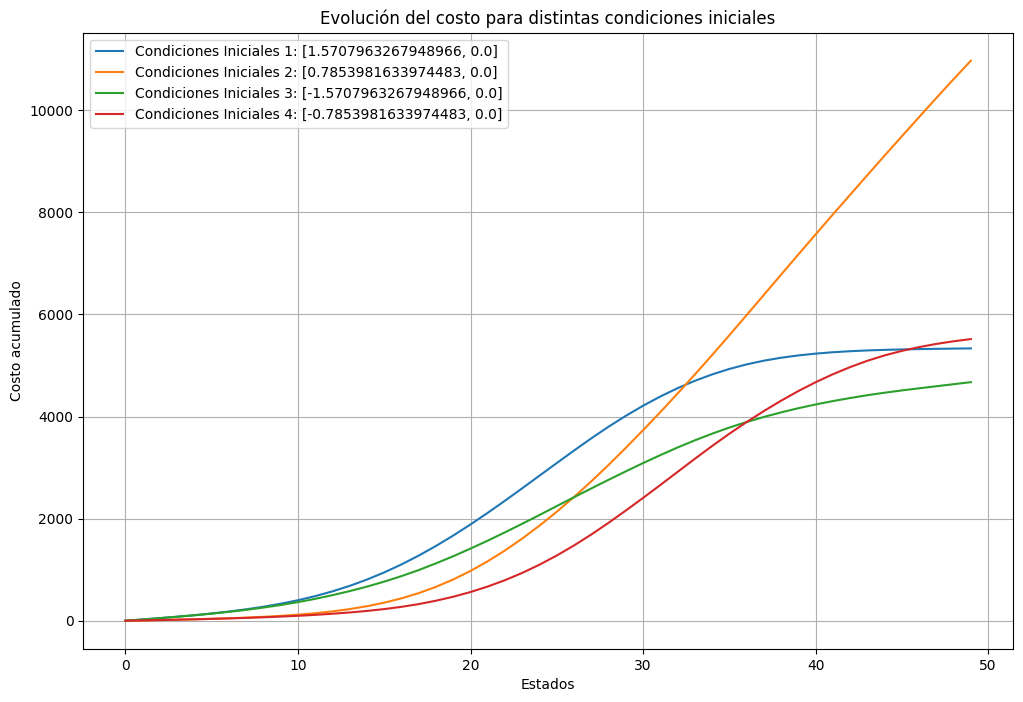

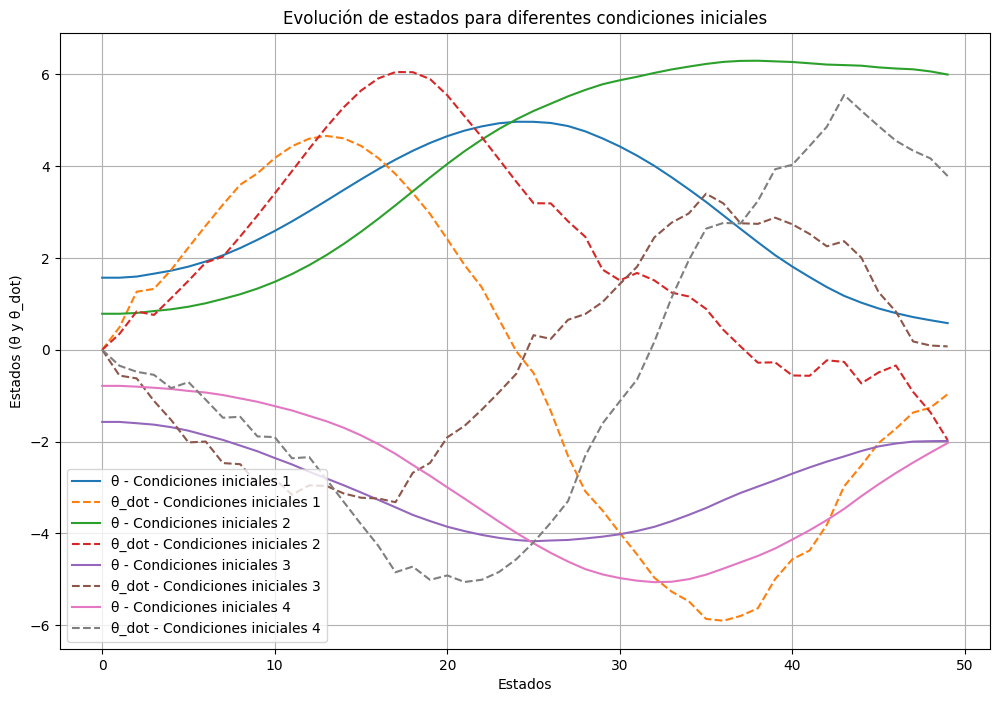

In [15]:
# Simulación para distintas condiciones inciales
initial_conditions = [[np.pi / 2, 0.0], [np.pi / 4, 0.0], [-np.pi / 2, 0.0], [-np.pi / 4, 0.0]]
num_conditions = len(initial_conditions)

costo_results = np.zeros((num_conditions, etapas))
estado_theta = np.zeros((num_conditions, etapas))
estado_theta_dot = np.zeros((num_conditions, etapas))
u_opt = np.zeros((num_conditions, etapas - 1))

for i, CI in enumerate(initial_conditions):
    theta, theta_dot = CI
    estado_theta[i, 0] = theta
    estado_theta_dot[i, 0] = theta_dot

    for k in range(etapas - 1):
        entrada = [k, theta, theta_dot]
        u = pol_tab_mu1(entrada, M_est, Ya)
        u_opt[i, k] = u
        theta, theta_dot = pendulum_dynamics(theta, theta_dot, u)

        costo_results[i, k + 1] = costo_results[i, k] + cost_function(theta, theta_dot, u)

        estado_theta[i, k + 1] = theta
        estado_theta_dot[i, k + 1] = theta_dot

plt.figure(figsize=(12, 8))

for i in range(num_conditions):
    plt.plot(costo_results[i], label=f"Condiciones Iniciales {i + 1}: {initial_conditions[i]}")

plt.title("Evolución del costo para distintas condiciones iniciales")
plt.xlabel("Estados")
plt.ylabel("Costo acumulado")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))

for i in range(num_conditions):
    plt.plot(estado_theta[i], label=f"θ - Condiciones iniciales {i + 1}")
    plt.plot(estado_theta_dot[i], '--', label=f"θ_dot - Condiciones iniciales {i + 1}")

plt.title("Evolución de estados para diferentes condiciones iniciales")
plt.xlabel("Estados")
plt.ylabel("Estados (θ y θ_dot)")
plt.legend()
plt.grid(True)
plt.show()


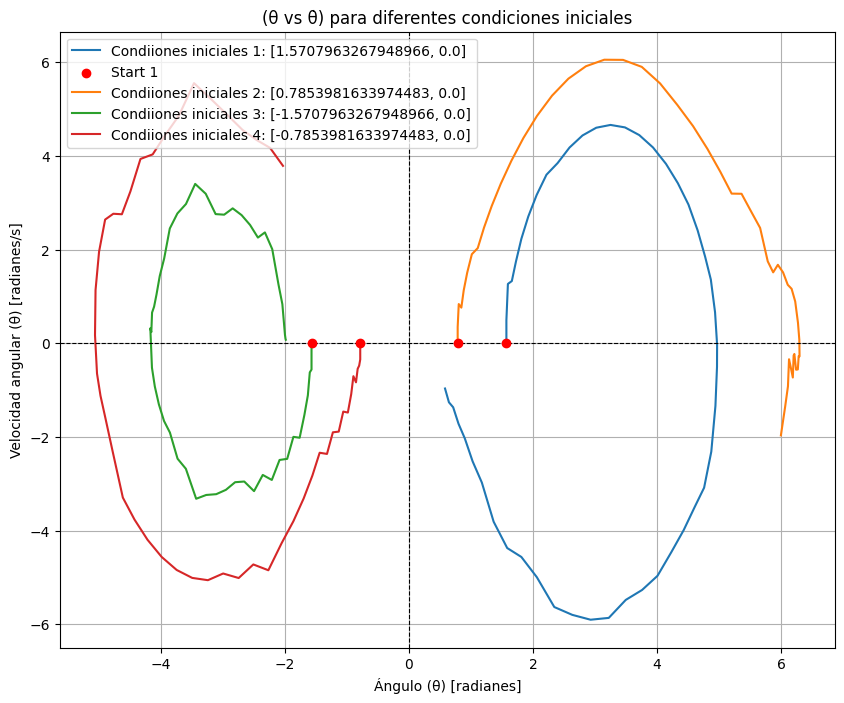

In [16]:
plt.figure(figsize=(10, 8))

for i in range(num_conditions):
    plt.plot(estado_theta[i], estado_theta_dot[i], label=f"Condiiones iniciales {i + 1}: {initial_conditions[i]}")
    plt.scatter(estado_theta[i, 0], estado_theta_dot[i, 0], color='red', label=f"Start {i + 1}" if i == 0 else None, zorder=5)

plt.title("(θ vs θ̇) para diferentes condiciones iniciales")
plt.xlabel("Ángulo (θ) [radianes]")
plt.ylabel("Velocidad angular (θ̇) [radianes/s]")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True)
plt.legend()
plt.show()


### Ejercicio N°3. Algoritmos de programación dinámica regresiva y aproximada

#### Programación Dinámica Recursiva

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Definimos Parametros

In [48]:
alfa = 10
Nmax = 3 * alfa   # Número de puntos en la grilla para el estado (x)
Mmax = 3 * alfa   # Número de puntos en la grilla para el control (u)
color = '.-k'     # Estilo de color para los gráficos

Nmax y Mmax determinan la resolución de las grillas para estados y controles.

In [49]:
dx = Nmax  # Número de puntos de la grilla de estados
du = Mmax  # Número de puntos de la grilla de control
x1 = np.zeros(dx)  # Vector de estados inicializado en ceros
etapas = 5  # Número de etapas
xmin, xmax = 0, 3  # Rango de valores para el estado
umin, umax = -1, 1  # Rango de valores para el control

xmuno = -10 * np.ones((etapas, dx))  # Inicializa la tabla de estados
uopt = 1e3 * np.ones((etapas, dx))   # Inicializa la tabla de controles óptimos
costomin = 1e7 * np.ones((etapas, dx))  # Inicializa la tabla de costos mínimos
Ax = (xmax - xmin) / (Nmax - 1)  # Paso entre estados
Au = (umax - umin) / (Mmax - 1)  # Paso entre controles


xmuno, uopt y costomin se inicializan con valores grandes para ser actualizados más adelante.

In [50]:
x = np.array([xmin + Ax * i for i in range(Nmax)])  # Grilla para el estado
u = np.array([umin + Au * i for i in range(Mmax)])  # Grilla para el control


Crea arreglos con valores uniformemente distribuidos dentro de los rangos definidos para x y u.

In [51]:
CI = 2  # Estado inicial
val, posi_x = min((abs(xi - CI), idx) for idx, xi in enumerate(x))  # Encuentra el estado más cercano a CI


In [52]:
for ii in range(dx):
    costomin[etapas - 1, ii] = abs(x[ii] - 1)

Establece los costos en la última etapa como la distancia absoluta entre cada estado y un valor objetivo (1).

In [53]:
for k in range(etapas - 2, -1, -1):  # Recorre las etapas en orden inverso
    for posi_x in range(dx):         # Recorre cada estado posible
        for i in range(du):          # Prueba todos los controles
            xy = mopdm(k, x[posi_x], u[i])  # Calcula el siguiente estado
            ele = indice(k, x[posi_x], u[i])  # Calcula el costo asociado
            val, lugar = min((abs(xi - xy), idx) for idx, xi in enumerate(x))  # Encuentra el estado más cercano
            JJ = costomin[k + 1, lugar] + ele  # Calcula el costo total

            if JJ < costomin[k, posi_x]:  # Si el costo es menor, actualiza
                costomin[k, posi_x] = JJ
                uopt[k, posi_x] = u[i]  # Almacena el control óptimo

Implementa programación dinámica para encontrar el costo mínimo y el control óptimo en cada etapa, partiendo desde el final.

In [54]:
costo = np.zeros((4, etapas))
estado = np.zeros_like(costo)
u_opt = np.zeros_like(costo)

for CI in range(1, 5):  # Itera para diferentes condiciones iniciales
    in_val = CI - 1
    estado[CI - 1, 0] = in_val

    for k in range(etapas - 1):
        val, lugar = min((abs(xi - in_val), idx) for idx, xi in enumerate(x))  # Encuentra el estado más cercano
        an = uopt[k, lugar]  # Control óptimo
        u_opt[CI - 1, k] = an
        costo[CI - 1, k + 1] = indice(k, in_val, an) + costo[CI - 1, k]  # Actualiza el costo
        in_val = mopdm(k, in_val, an)  # Calcula el próximo estado
        estado[CI - 1, k + 1] = in_val

    costo[CI - 1, -1] += abs(in_val - 1)


Reconstruye las trayectorias óptimas para diferentes condiciones iniciales (CI), calculando:
Estados (estado).
Costos (costo).
Controles óptimos (u_opt).

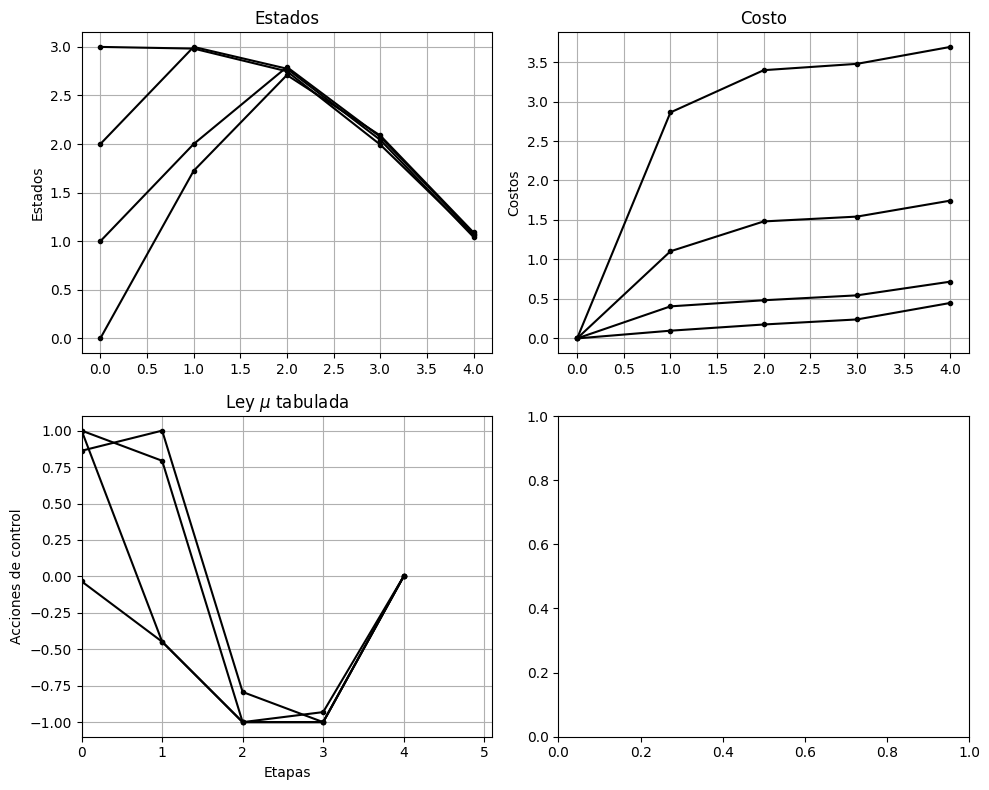

In [56]:
xx = np.arange(etapas)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(xx, estado.T, color)
axs[0, 0].set_title('Estados')
axs[0, 0].set_ylabel('Estados')
axs[0, 0].grid(True)

axs[0, 1].plot(xx, costo.T, color)
axs[0, 1].set_title('Costo')
axs[0, 1].set_ylabel('Costos')
axs[0, 1].grid(True)

axs[1, 0].plot(xx[:u_opt.shape[1]], u_opt.T, color)
axs[1, 0].set_title('Ley $\mu$ tabulada')
axs[1, 0].set_ylabel('Acciones de control')
axs[1, 0].set_xlabel('Etapas')
axs[1, 0].grid(True)
axs[1, 0].set_xlim(0, 5.1)
axs[1, 0].set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.show()


#### Programación dínamica recursiva caso del péndulo invertido

Procedemos a presentar una posible implementación de la programación dinamica recursiva para el problema del péndulo invertido



In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
g = 9.8  # Gravedad (m/s^2)
L = 1.0  # Largo del péndulo (m)
m = 1.0  # Masa del pendulo (kg)
dt = 0.05  # Delta tiempo
etapas = 50  # Número de etapas
Nmax = 50  # Número de grilla de estados
Mmax = 10  # Número de grilla de acciones

In [18]:
theta_min, theta_max = -np.pi, np.pi  # rango de los ángulos
theta_dot_min, theta_dot_max = -5, 5  # rango de la velocidad ángular
u_min, u_max = -10, 10  # Rango del control

In [19]:
# Grilla estado-acción
theta_grid = np.linspace(theta_min, theta_max, Nmax)
theta_dot_grid = np.linspace(theta_dot_min, theta_dot_max, Nmax)
u_grid = np.linspace(u_min, u_max, Mmax)

# Inicializamos la tabla de costo, estado y acción
costomin = np.full((etapas, Nmax, Nmax), 1e7)  # costo inicial
uopt = np.full((etapas, Nmax, Nmax), 1e3)  # acciones optimas
# Inicializamos el costo para la estapa final con costo final abs(theta)
for i_theta, theta in enumerate(theta_grid):
    for i_theta_dot in range(Nmax):  # No penalty for angular velocity in final stage
        costomin[etapas - 1, i_theta, i_theta_dot] = abs(theta)

In [21]:
# Dinámica del péndulo
def pendulum_dynamics(theta, theta_dot, u):
    theta_ddot = (g / L) * np.sin(theta) + u / (m * L**2)
    theta_new = theta + theta_dot * dt
    theta_dot_new = theta_dot + theta_ddot * dt
    return theta_new, theta_dot_new

# Función de costo mínima energía
def cost_function(theta, theta_dot, u):
    return 10*theta**2 + 0.1 * theta_dot**2 + 0.01 * u**2

In [23]:
# Programación dínamica recursiva, procedemos a completar la tabla
for k in range(etapas - 2, -1, -1):
    for i_theta, theta in enumerate(theta_grid):
        for i_theta_dot, theta_dot in enumerate(theta_dot_grid):
            for i_u, u in enumerate(u_grid):
                # Siguiente estado
                theta_new, theta_dot_new = pendulum_dynamics(theta, theta_dot, u)

                # Encontramos el punto mas cercano en la grilla para el nuevo estado
                i_theta_new = np.argmin(np.abs(theta_grid - theta_new))
                i_theta_dot_new = np.argmin(np.abs(theta_dot_grid - theta_dot_new))

                # Costo total
                immediate_cost = cost_function(theta, theta_dot, u)
                total_cost = immediate_cost + costomin[k + 1, i_theta_new, i_theta_dot_new]

                # Actualizamos la grilla con los costos y acciones
                if total_cost < costomin[k, i_theta, i_theta_dot]:
                    costomin[k, i_theta, i_theta_dot] = total_cost
                    uopt[k, i_theta, i_theta_dot] = u

In [24]:
# Simulamos las trayectorias para distintas condiciones iniciales
initial_conditions = [[0, 0], [np.pi / 2, 0], [-np.pi / 2, 0]]
num_conditions = len(initial_conditions)

estado_theta = np.zeros((num_conditions, etapas))
estado_theta_dot = np.zeros((num_conditions, etapas))
control_trajectory = np.zeros((num_conditions, etapas - 1))
cost_trajectory = np.zeros((num_conditions, etapas))

for i, (theta0, theta_dot0) in enumerate(initial_conditions):
    estado_theta[i, 0] = theta0
    estado_theta_dot[i, 0] = theta_dot0

    for k in range(etapas - 1):
        # Buscamos el punto mas cercano en la grilla
        i_theta = np.argmin(np.abs(theta_grid - estado_theta[i, k]))
        i_theta_dot = np.argmin(np.abs(theta_dot_grid - estado_theta_dot[i, k]))

        # Control óptimo
        u = uopt[k, i_theta, i_theta_dot]
        control_trajectory[i, k] = u

        # Próxima etapa
        theta_new, theta_dot_new = pendulum_dynamics(estado_theta[i, k], estado_theta_dot[i, k], u)
        estado_theta[i, k + 1] = theta_new
        estado_theta_dot[i, k + 1] = theta_dot_new

        # Costo apróximado
        cost_trajectory[i, k + 1] = cost_trajectory[i, k] + cost_function(theta_new, theta_dot_new, u)

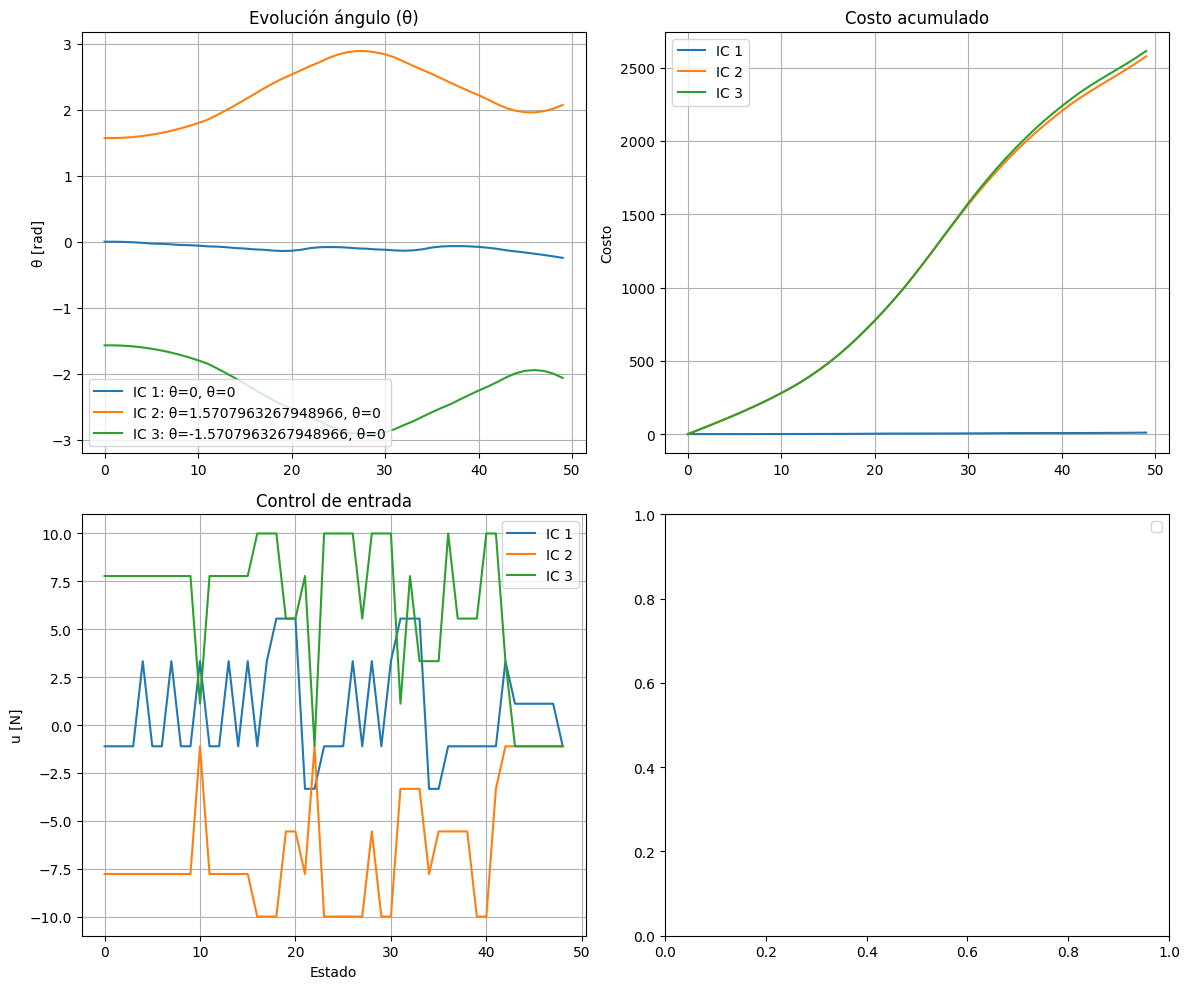

In [25]:
xx = np.arange(etapas)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i in range(num_conditions):
    axs[0, 0].plot(xx, estado_theta[i], label=f"IC {i+1}: θ={initial_conditions[i][0]}, θ̇={initial_conditions[i][1]}")
    axs[0, 1].plot(xx, cost_trajectory[i], label=f"IC {i+1}")
    axs[1, 0].plot(xx[:-1], control_trajectory[i], label=f"IC {i+1}")

axs[0, 0].set_title('Evolución ángulo (θ)')
axs[0, 0].set_ylabel('θ [rad]')
axs[0, 0].grid(True)

axs[0, 1].set_title('Costo acumulado')
axs[0, 1].set_ylabel('Costo')
axs[0, 1].grid(True)

axs[1, 0].set_title('Control de entrada')
axs[1, 0].set_ylabel('u [N]')
axs[1, 0].set_xlabel('Estado')
axs[1, 0].grid(True)

for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()


Subgráficos:
Estados en función de las etapas.
Costos acumulados.
Controles óptimos en cada etapa.

#### Programación dinamica aproximada


Procedermos a implemetnar un algoritmo de programación dinámica aproximada para el caso del péndulo invertido

In [26]:
def pmntanh(x):
    t = 1 - 2 / (np.exp(2 * x) + 1)
    return t

In [28]:
import numpy as np

def marq(NetDef, W1, W2, PHI, Yo, trparms):
    """
    Marquardt-Levenberg algorithm to update weights W1 and W2.

    Args:
        NetDef: np.array defining the network structure.
        W1: Initial weights for the first layer.
        W2: Initial weights for the second layer.
        PHI: Input features (n_features, n_samples).
        Yo: Target outputs (n_samples,).
        trparms: Training parameters [maxiter, stop_crit, lambda_, D].

    Returns:
        W1: Updated weights for the first layer.
        W2: Updated weights for the second layer.
        PI_vector: Performance index over iterations.
        iter: Total number of iterations performed.
        stop_flag: Convergence flag (0: not converged, 1: converged).
    """
    maxiter, stop_crit, lambda_, D = trparms
    n_samples = PHI.shape[1]

    PI_vector = []
    stop_flag = 0
    iter_count = 0

    for iter_count in range(maxiter):
        # Forward pass
        H = np.tanh(np.dot(W1, np.vstack([PHI, np.ones(n_samples)])))  # Hidden layer
        Y = np.dot(W2, np.vstack([H, np.ones(H.shape[1])]))  # Output layer

        # Compute error and performance index
        E = Yo - Y
        PI = np.mean(E**2)
        PI_vector.append(PI)

        # Check stopping criterion
        if PI < stop_crit:
            stop_flag = 1
            break

        # Backpropagation: Compute gradients
        dW2 = -2 * np.dot(E, np.vstack([H, np.ones(H.shape[1])]).T) / n_samples
        delta_h = (1 - H**2) * np.dot(W2[:, :-1].T, E)
        dW1 = -2 * np.dot(delta_h, np.vstack([PHI, np.ones(n_samples)]).T) / n_samples

        # Update weights using Marquardt-Levenberg adjustment
        W2_delta = np.linalg.inv(np.dot(dW2, dW2.T) + lambda_ * np.eye(W2.shape[0])) @ dW2
        W1_delta = np.linalg.inv(np.dot(dW1, dW1.T) + lambda_ * np.eye(W1.shape[0])) @ dW1

        W2 -= W2_delta
        W1 -= W1_delta

        # Adjust lambda (Marquardt-Levenberg parameter)
        if PI_vector[-1] < PI:
            lambda_ /= 10
        else:
            lambda_ *= 10

    return W1, W2, PI_vector, iter_count, stop_flag


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Constantes físicas del péndulo
g = 9.8  # Gravedad (m/s^2)
L = 1.0  # Largo del péndulo (m)
m = 1.0  # Masa del péndulo (kg)

In [30]:
# Dinámicas del péndulo
def pendulum_dynamics(theta, theta_dot, u, dt=0.05):
    theta_ddot = (g / L) * np.sin(theta) + (u / (m * L**2))
    theta_new = theta + theta_dot * dt
    theta_dot_new = theta_dot + theta_ddot * dt
    return theta_new, theta_dot_new

# Costo de mínima energía
def cost_function(theta, theta_dot, u):
    return 10*theta**2 + 0.1 * theta_dot**2 + 0.01 * u**2

# Tabla acción-estado
def pol_tab_mu1(entrada, M_est, Ya):
    diff = np.abs((entrada[0] - M_est[0, :]) / 3) + np.abs((entrada[1] - M_est[1, :]) / (2 * np.pi)) + np.abs((entrada[2] - M_est[2, :]) / 4)
    in_index = np.argmin(diff)
    return Ya[in_index]

In [31]:
# Inicialización
alfa = 4
Nmax = 4 * alfa
Mmax = 5 * alfa
color = '.-k'
dx = Nmax
du = Mmax
etapas = 50
xmin = -np.pi
xmax = np.pi
umin = -50
umax = 50
TM = 6 * Nmax * etapas

np.random.seed(0)

In [32]:
# Inicialización aleatoría
angles = 2 * np.pi * (np.random.rand(TM) - 0.5)  # ángulos iniciales (-pi a pi)
angular_velocities = 4 * (np.random.rand(TM) - 0.5)  # velocidad angular inicial (-2 a 2)
tiempo = np.ceil((etapas - 1) * np.random.rand(TM)).astype(int)
M_est = np.array([tiempo, angles, angular_velocities])

Au = (umax - umin) / (Mmax - 1)
uf = np.linspace(umin, umax, Mmax)

longx = 3
dd = 1
NetDef = np.array([['H', 'H', 'H', 'H', 'H'],
                   ['L', '-', '-', '-', '-']])

dm, ho = NetDef.shape
W1 = 0.1 * np.random.rand(ho, longx + 1)
W2 = 0.1 * np.random.rand(dd, ho + 1)
maxiter = 5
stop_crit = 0
lambda_ = 1
D = 0
trparms = [maxiter, stop_crit, lambda_, D]

CI = [np.pi/2, 0.0]  # condiciones iniciales
vfinal = [0.0, 0.0]  # Estado final

gama = [0.1]
Q = np.zeros((TM, du))
J = np.zeros(TM)
sal = np.zeros((etapas,2))
costo = np.zeros(etapas)
sal[0] = CI
costo[0] = 0
Ya = np.zeros(TM)
evoluc = [costo[etapas-1]]
consigna = np.zeros(etapas)

<ipython-input-46-f69ec9a39df0>:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_val[kval] = np.dot(W2, y1)
<ipython-input-46-f69ec9a39df0>:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[iq, acc] = cost_function(x1, x2, uf[acc]) + gama[iterac] * y2


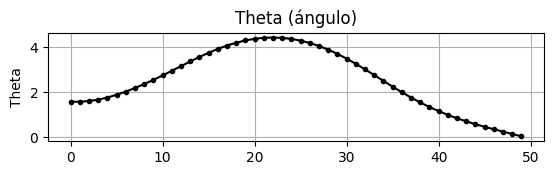

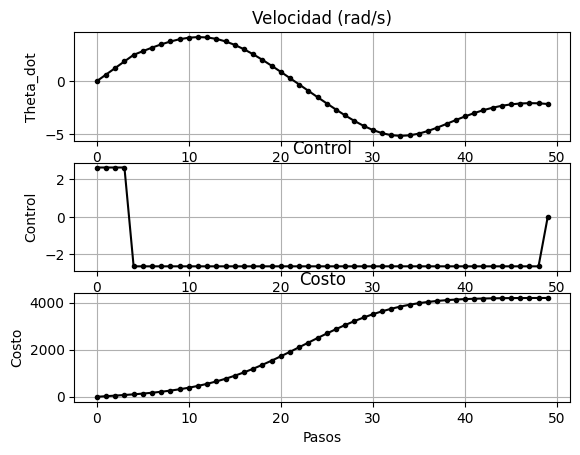

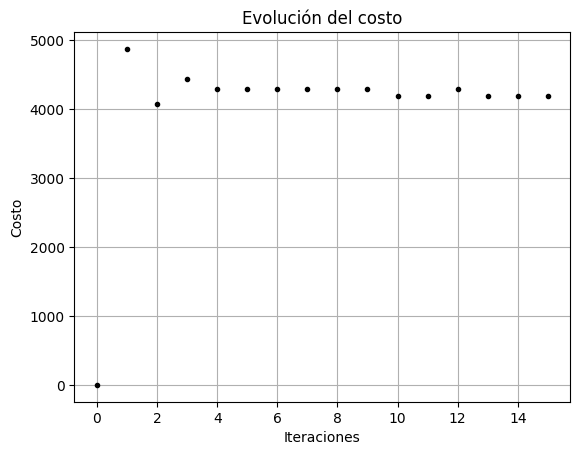

In [46]:
# Programación dinámica
for iterac in range(15):
    Yo = np.zeros(TM)
    PHI = np.zeros((3, TM))
    # itereamos todas las muestras
    for iq in range(TM):
        Jc = 0
        state = M_est[:, iq]
        x = state[1:]
        kini = state[0]
        PHI[0, iq] = kini
        PHI[1, iq] = x[0]
        PHI[2, iq] = x[1]
        # iteramos desde k hasta el final y obtenemos el costo acumulado
        for k in range(int(kini), etapas - 1):
            entrada = [k, x[0],x[1]]
            u = pol_tab_mu1(entrada, M_est, Ya)
            xy = pendulum_dynamics(entrada[1], entrada[2], u)

            if xmin <= xy[0] <= xmax:
                if k < etapas - 1:
                    Jc += cost_function(x[0], x[1], u)
                    x = xy
                else:
                    Jc += cost_function(x[0], x[1], u) + abs(xy[0] - vfinal[0])
            else:
                if xy[0] > xmax:
                    Jc += 5 * abs(xmax - xy[0])
                if xy[0] < xmin:
                    Jc += 5 * abs(xy[0] - xmin)
                break
        Yo[iq] = Jc
    # creamos los conjuntos de ajuste y validación
    Val_aj = round(0.8 * len(Yo))
    Val_val = len(Yo) - Val_aj
    Y_val = np.zeros(Val_val)
    PI_val = np.zeros(51)
    PI_val[0] = 1e10
    PI_aj = np.zeros(51)
    # entrenamos la red para obtener los pesos
    for veces in range(50):
        W1_old = W1.copy()
        W2_old = W2.copy()
        # actualizamos los pesos con el algoritmo marq
        W1, W2, PI_vector, _, _ = marq(NetDef, W1, W2, PHI[:, :Val_aj], Yo[:Val_aj], trparms)
        PI_aj[veces] = PI_vector[-1]

        for kval in range(Val_val):
            entrada = PHI[:, Val_aj + kval]
            X = np.concatenate([entrada, [1]])
            s1 = np.dot(W1, X)
            y1 = np.tanh(s1)
            y1 = np.concatenate([y1, [1]])  # agregamos el sesgo
            Y_val[kval] = np.dot(W2, y1)

        PI_val[veces + 1] = np.sum((Y_val - Yo[Val_aj:]) ** 2)

        if PI_val[veces + 1] > PI_val[veces]:
            W1 = W1_old
            W2 = W2_old
            break

    # Actuliazamos lo valores de Q con las apromiximaciones
    for iq in range(TM):
        k = M_est[0, iq]
        x1 = M_est[1, iq]
        x2 = M_est[2, iq]
        # iteramos cada acción
        for acc in range(du):
            xy = pendulum_dynamics(x1, x2, uf[acc])
            entrada = [k + 1, xy[0],xy[1]]
            # utilizamos los pesos de la red para calcular el costo aproximado
            X = np.concatenate([entrada, [1]])
            s1 = np.dot(W1, X)
            y1 = np.tanh(s1)
            y1 = np.concatenate([y1, [1]])
            y2 = np.dot(W2, y1)
            y2 = np.maximum(0, y2)

            if k < etapas - 1:
                Q[iq, acc] = cost_function(x1, x2, uf[acc]) + gama[iterac] * y2
            else:
                Q[iq, acc] = cost_function(x1, x2, uf[acc]) + abs(xy[0] - vfinal[0])

    # Actualizamos la política y el costo
    for iq in range(TM):
        val, lugar = np.min(Q[iq, :]), np.argmin(Q[iq, :])
        J[iq] = val
        Ya[iq] = uf[lugar]

    Q11 = Q[50, 0]
    gama.append(5 * iterac / (5 + 5 * iterac))

    sal[0] = CI
    costo = np.zeros(etapas)
    # simulamos un trayectoria para la condición inicial
    for k in range(etapas - 1):
        entrada = [k, sal[k][0],sal[k][1]]
        consigna_k = pol_tab_mu1(entrada, M_est, Ya)
        consigna[k] = consigna_k
        sal[k + 1] = pendulum_dynamics(entrada[1], entrada[2], consigna_k)
        costo[k + 1] = costo[k] + cost_function(sal[k][0],sal[k][1], consigna_k)

    costo[k + 1] = costo[k + 1] + abs(sal[k + 1][0] - vfinal[0])
    evoluc.append(costo[etapas - 1])


uo = consigna
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(range(etapas), sal[:,0], color)
plt.title('Theta (ángulo)')
plt.ylabel('Theta')
plt.grid(True)

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(range(etapas), sal[:,1], color)
plt.title('Velocidad (rad/s)')
plt.ylabel('Theta_dot')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(range(etapas), uo, color)
plt.title('Control')
plt.ylabel('Control')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(range(etapas), costo, color)
plt.title('Costo')
plt.ylabel('Costo')
plt.xlabel('Pasos')
plt.grid(True)

plt.show()

plt.figure()
plt.plot(evoluc, '.k')
plt.xlabel('Iteraciones')
plt.ylabel('Costo')
plt.title('Evolución del costo')
plt.grid(True)
plt.show()